In [1]:
import json
from pymatgen.core import Lattice, Structure, Molecule

In [2]:
def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)

In [3]:
import os

filepath_train = 'dichalcogenides_public/structures/'
train_files = os.listdir(filepath_train)

filepath_test = 'dichalcogenides_private/structures/'
test_files = os.listdir(filepath_test)

In [307]:
import numpy as np

def graph_to_img(crystal):
    # Transform to dictionary
    crystal_d = crystal.as_dict()
    
    # Retrieve coordinates relative to grid
    abc = np.array([aux['abc'] for aux in crystal_d['sites']])
    abc_t = abc.transpose()
    a = set(abc_t[0])
    b = set(abc_t[1])
    c = set(abc_t[2])

    # Dictionaries to transform from abc to grid index
    a_parser = dict(list(zip(sorted(a), range(len(a)))))
    b_parser = dict(list(zip(sorted(b), range(len(b)))))
    c_parser = dict(list(zip(sorted(c), range(len(c)))))

    coords = [(a_parser[x['abc'][0]], b_parser[x['abc'][1]], c_parser[x['abc'][2]], x['label']) for x in crystal_d['sites']] 
    
    # Transform element label to atomic number
    Z = {'Mo': 42, 'W': 74, 'S': 16, 'Se': 34}
    coords = [(x[0] // 2, x[1] // 2, x[2], Z[x[3]]) for x in coords]
    
    # Add missing atoms of the grid with atomic number of 0
    grid = set([(i,j) for i in range(8) for j in range(8)])

    crystal_grid0 = set([(x[0],x[1]) for x in coords if x[2] == 0])
    crystal_grid1 = set([(x[0],x[1]) for x in coords if x[2] == 1])
    crystal_grid2 = set([(x[0],x[1]) for x in coords if x[2] == 2])

    dif0 = grid.difference(crystal_grid0)
    dif1 = grid.difference(crystal_grid1)
    dif2 = grid.difference(crystal_grid2)
    
    add0 = [(x[0], x[1], 0, 0) for x in dif0]
    add1 = [(x[0], x[1], 1, 0) for x in dif1]
    add2 = [(x[0], x[1], 2, 0) for x in dif2]
    
    coords.extend(add0)
    coords.extend(add1)
    coords.extend(add2)
    
    assert((8*8*3 - len(coords)) == 0)
    
    # Sort and reshape into image
    coords.sort(key=lambda x: (x[2],x[0],x[1]))
    coords = np.array(coords, dtype=np.uint8)

    coords_v = coords[:,3]
    img = coords_v.reshape((3,8,8))
    img = img.transpose((1,2,0))
    return img

In [376]:
import matplotlib.pyplot as plt

def plot_crystal(crystal):
    img = graph_to_img(crystal)
    fig, ax = plt.subplots(1,3, figsize=(10,10))
    im = ax[0].imshow(img[:,:,0], cmap='Blues', vmin=0, vmax=255)
    im = ax[1].imshow(img[:,:,1], cmap='Blues', vmin=0, vmax=255)
    im = ax[2].imshow(img[:,:,2], cmap='Blues', vmin=0, vmax=255)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.4, 0.03, 0.2])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

In [386]:
file = train_files[30]
crystal = read_pymatgen_dict(filepath_train+file)

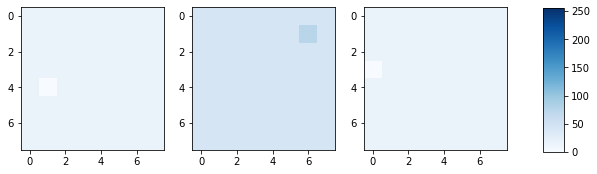

CPU times: user 507 ms, sys: 22.8 ms, total: 530 ms
Wall time: 493 ms


In [388]:
%%time
plot_crystal(crystal)

In [387]:
%%time
img = graph_to_img(crystal)

CPU times: user 33.8 ms, sys: 6.99 ms, total: 40.8 ms
Wall time: 38.6 ms


In [407]:
for file in train_files:
    crystal = read_pymatgen_dict(filepath_train+file)
    img = graph_to_img(crystal)
    np.save(filepath_train[:-11] + 'images/' + file[:-5], img)

In [408]:
%%time
for file in test_files:
    crystal = read_pymatgen_dict(filepath_test+file)
    img = graph_to_img(crystal)
    np.save(filepath_test[:-11] + 'images/' + file[:-5], img)

CPU times: user 1min 17s, sys: 1.53 s, total: 1min 19s
Wall time: 1min 21s
